In [63]:
!nvidia-smi


Sat Jul 20 07:07:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |   3549MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [64]:
import torch
torch.cuda.is_available()

True

In [65]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [66]:
class CNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=2):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=stride,padding=1,bias=False,padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.LeakyReLU(0.2)

        )
    def forward(self,X):
        return self.conv(X)


In [67]:
class Discriminator(nn.Module):
    def __init__(self,in_channels=3,features=[64,128,256,512]):
        super().__init__()
        self.initial=nn.Sequential(
            nn.Conv2d(in_channels=in_channels*2,out_channels=features[0],kernel_size=4,stride=2,padding=1,padding_mode='reflect'), #in_channels*2 coz we send x*y in concat(by channels) form.
            nn.LeakyReLU(0.2)
        )
        layers=[]
        in_channels=features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels=in_channels,out_channels=feature,stride=1 if feature == features[-1] else 2)
            )
            in_channels=feature
        layers.append(
            nn.Conv2d(in_channels=in_channels,out_channels=1,kernel_size=4,stride=1,padding=1,padding_mode='reflect')
        )
        self.model=nn.Sequential(*layers)

    def forward(self,x,y):
        x=torch.cat([x,y],dim=1)
        x=self.initial(x)
        return self.model(x)


In [68]:
def test():
    X=torch.randn(size=(1,3,256,256))
    y=torch.randn(size=(1,3,256,256))
    model=Discriminator()
    pred=model(X,y)
    print(pred.shape)
    print("Test successfull !!!")

test()

torch.Size([1, 1, 30, 30])
Test successfull !!!


In [69]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,down=True,act='relu',use_dropout=False):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=2,padding=1,bias=False,padding_mode='reflect')
            if down
            else
            nn.ConvTranspose2d(in_channels=in_channels,out_channels=out_channels,kernel_size=4,stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(out_channels,affine=True),
            nn.ReLU() if act=='relu' else nn.LeakyReLU(0.2),

        )
        self.use_dropout=use_dropout
        self.dropout=nn.Dropout(0.5)

    def forward(self,x):
        x=self.conv(x)
        return self.dropout(x) if self.use_dropout else x


In [70]:
class Generator(nn.Module):
    def __init__(self,in_channels=3,features=64):
        super().__init__()
        #N*C*256*256
        self.initial_down=nn.Sequential(
            nn.Conv2d(in_channels=in_channels,out_channels=features,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),
            nn.LeakyReLU(0.2)
        )#N*64*128*128
        self.down1=Block(in_channels=features,out_channels=features*2,down=True,act='leaky',use_dropout=False)#N*128*64*64
        self.down2=Block(in_channels=features*2,out_channels=features*4,down=True,act='leaky',use_dropout=False)#N*256*32*32
        self.down3=Block(in_channels=features*4,out_channels=features*8,down=True,act='leaky',use_dropout=False)#N*512*16*16
        self.down4=Block(in_channels=features*8,out_channels=features*8,down=True,act='leaky',use_dropout=False)#N*512*8*8
        self.down5=Block(in_channels=features*8,out_channels=features*8,down=True,act='leaky',use_dropout=False)#N*512*4*4
        self.down6=Block(in_channels=features*8,out_channels=features*8,down=True,act='leaky',use_dropout=False)#N*512*2*2
        self.bottleneck=nn.Sequential(
            nn.Conv2d(in_channels=features*8,out_channels=features*8,kernel_size=4,stride=2,padding=1,padding_mode='reflect'),##N*512*1*1
            nn.ReLU()
        )
        self.up1=Block(in_channels=features*8,out_channels=features*8,down=False,act='relu',use_dropout=True)
        self.up2=Block(in_channels=features*8*2,out_channels=features*8,down=False,act='relu',use_dropout=True)
        self.up3=Block(in_channels=features*8*2,out_channels=features*8,down=False,act='relu',use_dropout=True)
        self.up4=Block(in_channels=features*8*2,out_channels=features*8,down=False,act='relu',use_dropout=False)
        self.up5=Block(in_channels=features*8*2,out_channels=features*4,down=False,act='relu',use_dropout=False)
        self.up6=Block(in_channels=features*4*2,out_channels=features*2,down=False,act='relu',use_dropout=False)
        self.up7=Block(in_channels=features*2*2,out_channels=features,down=False,act='relu',use_dropout=False)
        self.final_up=nn.Sequential(
            nn.ConvTranspose2d(in_channels=features*2,out_channels=in_channels,kernel_size=4,stride=2,padding=1),
            nn.Tanh()
        )


    def forward(self,x):
        d1=self.initial_down(x)
        d2=self.down1(d1)
        d3=self.down2(d2)
        d4=self.down3(d3)
        d5=self.down4(d4)
        d6=self.down5(d5)
        d7=self.down6(d6)
        bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck)
        up2=self.up2(torch.cat([up1,d7],dim=1))
        up3=self.up3(torch.cat([up2,d6],dim=1))
        up4=self.up4(torch.cat([up3,d5],dim=1))
        up5=self.up5(torch.cat([up4,d4],dim=1))
        up6=self.up6(torch.cat([up5,d3],dim=1))
        up7=self.up7(torch.cat([up6,d2],dim=1))
        return self.final_up(torch.cat([up7,d1],dim=1))




In [71]:
def testforGenerator():
    X=torch.randn(size=(1,3,256,256))
    model=Generator(in_channels=3,features=64)
    preds=model(X)
    print(preds.shape)

testforGenerator()

torch.Size([1, 3, 256, 256])


In [72]:
from PIL import Image
import numpy as np
import os
from torch.utils.data import Dataset


In [73]:

import albumentations as A
from albumentations.pytorch import ToTensorV2


LEARNING_RATE = 2e-4
BATCH_SIZE = 32
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 50
LOAD_MODEL = False
SAVE_MODEL = True



both_transform = A.Compose(
    [A.Resize(width=256, height=256),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        ToTensorV2(),
    ]
)

In [74]:
class MapDataSet():
    def __init__(self,root_dir):
        self.root_dir=root_dir
        self.list_files=os.listdir(self.root_dir)


    def __len__(self):
        return len(self.list_files)


    def __getitem__(self,index):
        img_file=self.list_files[index]
        img_path=os.path.join(self.root_dir,img_file)
        image=np.array(Image.open(img_path))
        input_image=image[:,:600,:]
        target_image=image[:,600:,:]
        augmentations=both_transform(image=input_image,image0=target_image)
        input_image,target_image=augmentations['image'],augmentations['image0']
        input_image=transform_only_input(image=input_image)['image']
        target_image=transform_only_mask(image=target_image)['image']

        return input_image,target_image





Text(0.5, 1.0, 'Image 2')

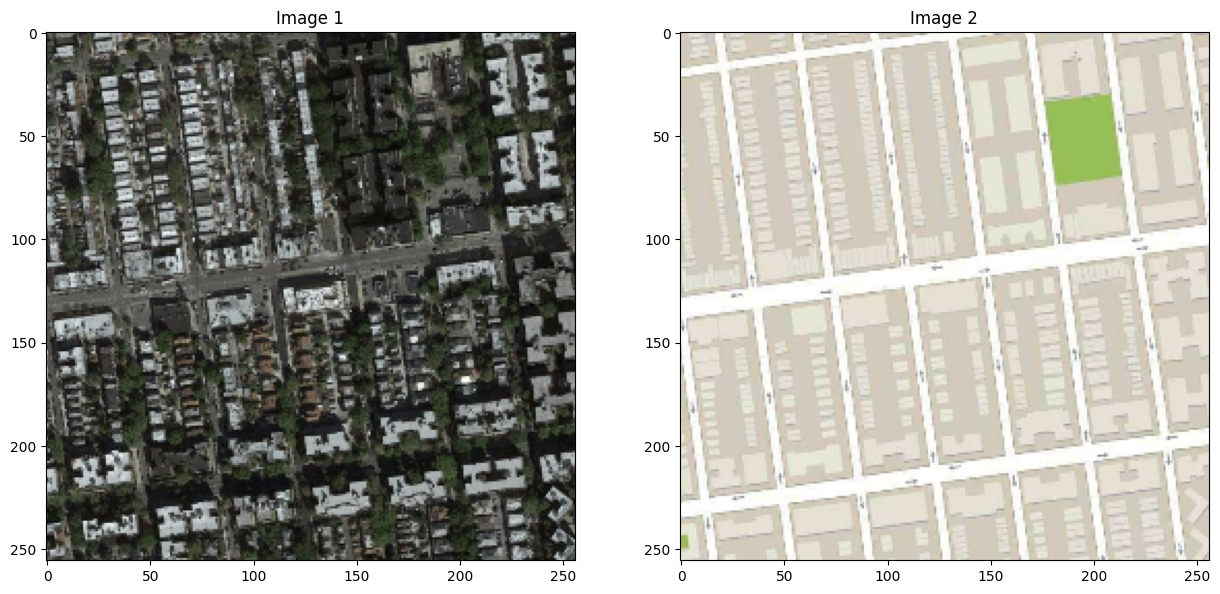

In [75]:
dataset=MapDataSet(root_dir='/content/drive/MyDrive/maps/train')
img1,img2=dataset[0][0],dataset[0][1]

if img1.min() < 0 or img1.max() > 1:
        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
if img2.min() < 0 or img2.max() > 1:
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))
plt.title('Image 2')




In [76]:
dataloader=DataLoader(dataset=dataset,batch_size=BATCH_SIZE,shuffle=True)
print(f"There are almost {len(dataloader)} batches of batch_size:{BATCH_SIZE}")

There are almost 35 batches of batch_size:32


In [78]:
g_scaler=torch.cuda.amp.GradScaler()
d_scaler=torch.cuda.amp.GradScaler()
val_dataset=MapDataSet(root_dir='/content/drive/MyDrive/maps/val')
val_loader=DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE,shuffle=False)

In [79]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device:{device}")

Using device:cuda


In [80]:
disc=Discriminator(in_channels=3).to(device)
gen=Generator(in_channels=3).to(device)
opt_disc=torch.optim.Adam(params=disc.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
opt_gen=torch.optim.Adam(params=gen.parameters(),lr=LEARNING_RATE,betas=(0.5,0.999))
BCE=nn.BCEWithLogitsLoss()
L1Loss=nn.L1Loss()


In [81]:
X,y=next(iter(dataloader))
print(X.shape)
print(y.shape)

torch.Size([32, 3, 256, 256])
torch.Size([32, 3, 256, 256])


In [84]:
for epoch in tqdm(range(NUM_EPOCHS)):
    for idx,(X,y) in enumerate(dataloader):
        X,y=X.to(device),y.to(device)
        with torch.cuda.amp.autocast():
            y_fake=gen(X)
            D_real=disc(X,y)
            D_fake=disc(X,y_fake.detach())
            D_real_loss=BCE(D_real,torch.ones_like(D_real))
            D_fake_loss=BCE(D_fake,torch.zeros_like(D_fake))
            D_loss=(D_real_loss+D_fake_loss) / 2

        disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        with torch.cuda.amp.autocast():
            D_fake=disc(X,y_fake)
            G_fake_loss=BCE(D_fake,torch.ones_like(D_fake))
            L1=L1Loss(y_fake,y) * L1_LAMBDA
            G_loss=G_fake_loss+ L1

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()








  0%|          | 0/50 [00:00<?, ?it/s]

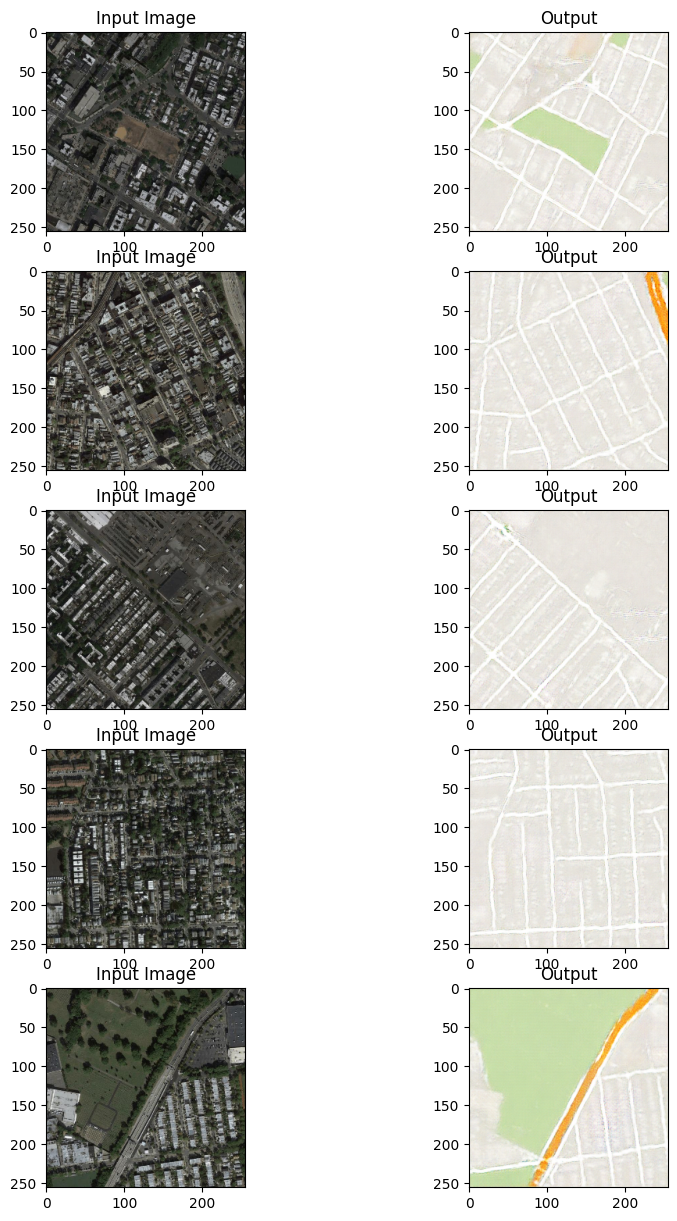

In [92]:
import random
device = 'cuda'
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    X,y = dataset[random.randint(1,50)]
    gen.eval()
    with torch.inference_mode():
        out =(gen(X.to(device).unsqueeze(0)) * 0.5) + 0.5
    gen.train()

    axes[i][0].imshow((X.cpu().detach().squeeze(0).permute(1,2,0)+1)/2)
    axes[i][0].set_title('Input Image')


    axes[i][1].imshow(out.cpu().squeeze(0).permute(1,2,0))
    axes[i][1].set_title('Output')

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
